In [1]:
import numpy as np

import keras
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPooling2D,\
    Activation, Dropout, GlobalAveragePooling2D, concatenate

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Load some images

In [2]:
local_images = [
    'dog.jpg', 'canoe.jpg', 'car.jpg', 'cat.jpg', 
    'tabby.jpg', 'submarine.jpg', 'snake.jpg', 'teapot.jpg'
]

In [3]:
pictures = np.zeros((8, 224, 224, 3))
for i, pic in enumerate(local_images):
    x = image.load_img('images/' + pic, target_size=(224, 224))
    pictures[i] = image.img_to_array(x)
    
pictures /= 255.0

# Model

In [4]:
# pretrained weights of SqueezeNet v1.1
weights = np.load('weights.npy')[()]

In [5]:
# a building block of the SqueezeNet architecture
def fire_module(number, x, squeeze, expand, trainable=False):
    
    module_name = 'fire' + number
    
    x = Convolution2D(
        squeeze, (1, 1), 
        name=module_name + '/' + 'squeeze',
        trainable=trainable
    )(x)
    x = Activation('relu')(x)

    a = Convolution2D(
        expand, (1, 1),
        name=module_name + '/' + 'expand1x1',
        trainable=trainable
    )(x)
    a = Activation('relu')(a)

    b = Convolution2D(
        expand, (3, 3), padding='same',
        name=module_name + '/' + 'expand3x3',
        trainable=trainable
    )(x)
    b = Activation('relu')(b)

    return concatenate([a, b])

In [6]:
def SqueezeNet():

    image = Input(shape=(224, 224, 3))

    x = Convolution2D(
        64, (3, 3), strides=(2, 2), name='conv1', 
        trainable=False
    )(image) # 111, 111, 64
    
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x) # 55, 55, 64

    x = fire_module('2', x, squeeze=16, expand=64) # 55, 55, 128
    x = fire_module('3', x, squeeze=16, expand=64) # 55, 55, 128
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x) # 27, 27, 128

    x = fire_module('4', x, squeeze=32, expand=128) # 27, 27, 256
    x = fire_module('5', x, squeeze=32, expand=128) # 27, 27, 256
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x) # 13, 13, 256

    x = fire_module('6', x, squeeze=48, expand=192) # 13, 13, 384
    x = fire_module('7', x, squeeze=48, expand=192) # 13, 13, 384
    x = fire_module('8', x, squeeze=64, expand=256) # 13, 13, 512
    x = fire_module('9', x, squeeze=64, expand=256) # 13, 13, 512
    x = Dropout(0.5)(x)
    
    x = Convolution2D(1000, (1, 1), name='conv10')(x) # 13, 13, 1000
    
    x = Activation('relu')(x)
    logits = GlobalAveragePooling2D()(x) # 1000
    classes = Activation('softmax')(logits)
    
    return Model(image, classes)

In [7]:
model = SqueezeNet()
model.count_params()

1235496

In [8]:
# load pretrained weights into the model
for k in [w for w in weights]:
    model.get_layer(k).set_weights(weights[k])

# Try it

In [9]:
# 1000 imagenet category names
class_names = np.load('imagenet_class_names.npy')

In [10]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [11]:
X = pictures.copy()
X -= mean
X /= std

predictions = model.predict(X)

In [12]:
# view class names with highest probability
predicted_classes = class_names[predictions.argsort()[:, 998:]]
predicted_probs = np.sort(predictions)[:, 998:]

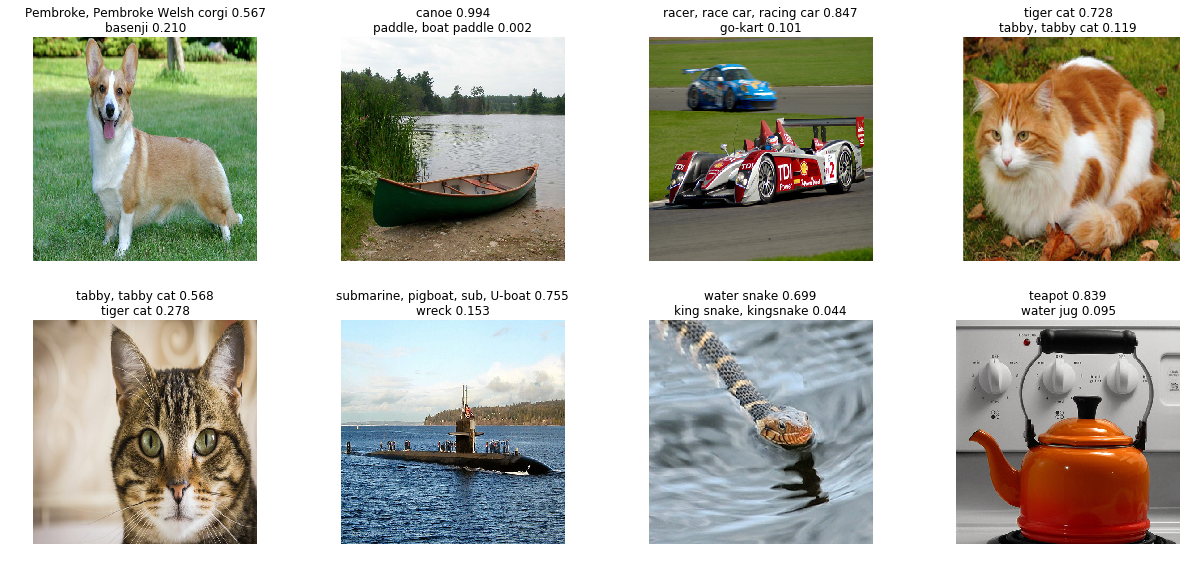

In [13]:
_, axes = plt.subplots(nrows=2, ncols=4, figsize=(17, 8))
axes = axes.flatten()
for i, pic in enumerate(pictures):
    axes[i].set_axis_off();
    axes[i].imshow(pic);
    
    title = (predicted_classes[i][-1] + ' {0:.3f}' +\
        '\n' + predicted_classes[i][-2] + ' {1:.3f}').\
        format(predicted_probs[i][-1], predicted_probs[i][-2])
    
    axes[i].set_title(title);

plt.tight_layout()